In [1]:
import pennylane as qml
from pennylane import numpy as np
import qemzmsepcV2new as qem

Cost after step     5:  0.6988960
Cost after step    10:  0.2704000
Cost after step    15:  0.0852640
Cost after step    20:  0.0457960
Cost after step    25:  0.1536640
Cost after step    30:  0.0912040
Cost after step    35:  0.0864360
Cost after step    40:  0.0718240
Cost after step    45:  0.0538240
Cost after step    50:  0.0129960
Cost after step    55:  0.0739840
Cost after step    60:  0.0556960
Cost after step    65:  0.0282240
Cost after step    70:  0.0384160
Cost after step    75:  0.0912040
Cost after step    80:  0.0510760
Cost after step    85:  0.0262440
Cost after step    90:  0.0432640
Cost after step    95:  0.0174240
Cost after step   100:  0.0158760
Optimized rotation angles: [[[ 0.58229928  1.53913853  0.01110326]
  [ 0.82072855  1.87138184 -0.12689192]]

 [[ 0.13355054  1.26856437  0.34130002]
  [ 0.80003663  0.47930835  0.61946073]]]


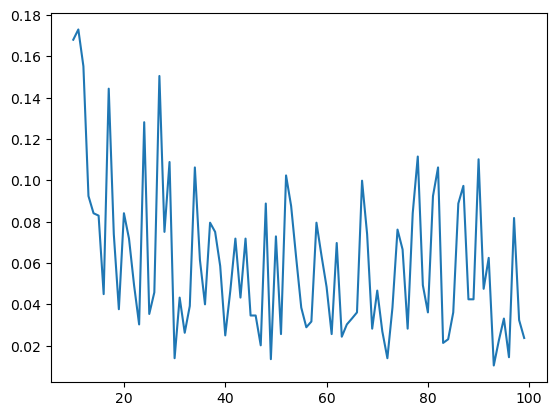

In [2]:
# we introduced noise into the network and trained it without any error mitigation techniques
# to observe the behavior of the Loss function degradation during training.

n_qubits = 2
dev = qml.device('default.mixed', wires=n_qubits, shots=1000)

nqubitschannel = qem.NqubitsChannel(n_qubits)
nqubitspaulichannel = nqubitschannel.nqubitsrandompaulichannel(p_identity=0.85)
p = 0.9

qemzmsepc = qem.QEMZMSEPC(n_qubits)

def train_cir_without_qem(parameters):
    qml.StronglyEntanglingLayers(weights=parameters, wires=range(2))

shape = qml.StronglyEntanglingLayers.shape(n_layers=2, n_wires=2)
weights = np.random.random(size=shape)

def cost(x):
    return (qml.QNode(qemzmsepc.noise_circuit, dev)(train_cir_without_qem, x, p=p,
            kraus_matrices_of_a_pauli_channel=nqubitspaulichannel,
            need_gate_noise=True, need_measurement_noise=True) - (-1)) ** 2

opt = qml.GradientDescentOptimizer(stepsize=0.1)
steps = 100
params = weights
loss = []

for i in range(steps):
    nqubitspaulichannel = nqubitschannel.nqubitsrandompaulichannel(p_identity=0.85)
    params = opt.step(cost, params)
    if (i + 1) % 5 == 0:
        print("Cost after step {:5d}: {: .7f}".format(i + 1, cost(params)))
    loss.append(cost(params))
print("Optimized rotation angles: {}".format(params))

# When simulating a complex scenario of time-varying noise channels,
# it can be observed that the descent of the Loss function is relatively unstable
# in the absence of error mitigation techniques.

import matplotlib.pyplot as plt
x = [i for i in range(10, 100)]
y = loss[10:]
plt.plot(x, y)
plt.show()

It is unstable to do error mitigation in this situation, so the unmitigated value is returned.
Cost after step     5:  1.5604561
It is unstable to do error mitigation in this situation, so the unmitigated value is returned.
It is unstable to do error mitigation in this situation, so the unmitigated value is returned.
Cost after step    10:  1.0732960
It is unstable to do error mitigation in this situation, so the unmitigated value is returned.
It is unstable to do error mitigation in this situation, so the unmitigated value is returned.
It is unstable to do error mitigation in this situation, so the unmitigated value is returned.
Cost after step    15:  0.4106817
Cost after step    20:  0.1439818
Cost after step    25:  0.0336297
Cost after step    30:  0.0837585
Cost after step    35:  0.0095644
Cost after step    40:  0.0220280
Cost after step    45:  0.0119826
Cost after step    50:  0.0127480
Cost after step    55:  0.0166489
Cost after step    60:  0.0062262
Cost after step    65:

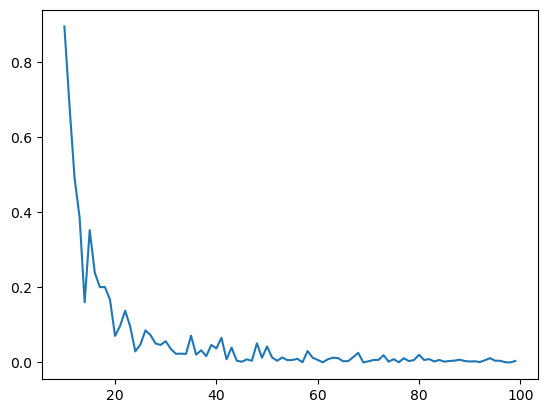

In [3]:
# training with QEM-ZMSEPC method

n_qubits = 2
dev = qml.device('default.mixed', wires=n_qubits, shots=1000)

nqubitschannel = qem.NqubitsChannel(n_qubits)
nqubitspaulichannel = nqubitschannel.nqubitsrandompaulichannel(p_identity=0.85)
p = 0.9

qemzmsepc = qem.QEMZMSEPC(n_qubits)

def train_cir_with_qem(parameters):
    qml.StronglyEntanglingLayers(weights=parameters, wires=range(2))

shape = qml.StronglyEntanglingLayers.shape(n_layers=2, n_wires=2)
weights = np.random.random(size=shape)

def cost(x):
    z_un = qml.QNode(qemzmsepc.noise_circuit, dev)(train_cir_with_qem, parameters=x, p=p,
        kraus_matrices_of_a_pauli_channel=nqubitspaulichannel, need_gate_noise=True, need_measurement_noise=True)
    z_miti, _ = qemzmsepc.qemzmsepc(train_cir_with_qem, z_un, p, dev, x,
            kraus_matrices_of_a_pauli_channel=nqubitspaulichannel)
    return (z_miti - (-1)) ** 2

opt = qml.GradientDescentOptimizer(stepsize=0.1)
steps = 100
params = weights
loss = []

for i in range(steps):
    nqubitspaulichannel = nqubitschannel.nqubitsrandompaulichannel(p_identity=0.85)
    params = opt.step(cost, params)
    if (i + 1) % 5 == 0:
        print("Cost after step {:5d}: {: .7f}".format(i + 1, cost(params)))
    loss.append(cost(params))
print("Optimized rotation angles: {}".format(params))

import matplotlib.pyplot as plt
x = [i for i in range(10, 100)]
y = loss[10:]
plt.plot(x, y)
plt.show()